# 2/2/2025

Brain perfusion, bi-exponential anomalous diffusion fit with four different methods


Code is not neatened up.

In [51]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv
import time
import datetime

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format

from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from statistics import mean


def func(x,m,b):
    return m*x + b

def triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_med*np.exp(-b*diff_med)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_med+frac_fast
    return Data/normal


## note here that diff_slow should be diff**gamma. instead it isn't. so it's slightly different. 

def anomalous_triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow, gamma_fast, gamma_med, gamma_slow):
    Data = frac_slow*np.exp(-(b*diff_slow)**gamma_slow)+frac_med*np.exp(-(b*diff_med)**gamma_med)+frac_fast*np.exp(-(b*diff_fast)**gamma_fast)
    normal = frac_slow+frac_med+frac_fast
    return Data/normal

def CalculatePE_fraction(df, trait):
    df[trait + ' PE'] = (df['Fit ' + trait]-df['true ' + trait])#*100/(df['true ' + trait])
    return df

def CalculatePE_diffusion(df, trait): #scale by 1000
    df[trait + ' PE'] = ((df['Fit ' +trait]/1000)-df['true ' + trait])#*100/(df['true ' + trait])
    return df

def blandalt_calc(FitfDs,TruefDs, name):
    mean_diff = np.mean(FitfDs-TruefDs)
    mean_diff_percent = 100*mean_diff/np.mean((FitfDs+TruefDs)/2)
    std_diff = np.std(FitfDs-TruefDs)
    std_diff_percent = 100*std_diff/np.mean((FitfDs+TruefDs)/2)
    lower_bound=mean_diff-(std_diff*1.96)
    upper_bound=mean_diff+(std_diff*1.96)
    lower_bound_percent=mean_diff_percent-(1.96*std_diff_percent)
    upper_bound_percent=mean_diff_percent+(1.96*std_diff_percent)
    print(f'{name} BA, {mean_diff:.3f}, [{lower_bound:.3f}-{upper_bound:.3f}]')
    print(f'{name} %BA, {mean_diff_percent:.3f}%, [{lower_bound_percent:.3f}%-{upper_bound_percent:.3f}%]\n')
    return
    
def func(x,m,b):
    return m*x + b


def biexp_func(b, frac_fast,frac_slow,diff_fast,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_fast
    return Data/normal

def monoexp_func(b, frac, diff):
    Data = frac*np.exp(-b*diff)
    return Data

#Rician noise check

#SNR = 1, sigma = 1
#SNR = 10, sigma = .1
#SNR = 20, sigma = .045
#SNR = 50, sigma = .02
#SNR = 75, sigma = .013
#SNR = 100, sigma = .01
#SNR = 125, sigma = .008
#SNR = 150, sigma = .0065
def NoiseRice(I,SNR): # noise with rician distribution
    N = [] 
    sigma = 1/SNR
    #v = .79 # calculated from images on 6/11/19
    #sigma = .013 #(std of noise measured!)
    #v = 0.00434 #scaled = .79/182
    v = .005816 #scaled 6/27/19
    b = v/sigma
    r = rice.rvs(b, scale = sigma, size=len(I))
    for i in range(0,len(I)):
        N.append(I[i] +r[i]) #SNR = 1,10,22,100,150,inf
    return N


def ExportToDF(df, IdentifyingInfo, data):
    if isinstance(data, list):
        Export = data
        Export.insert(0, IdentifyingInfo)
        df.loc[ len(df),: ] = Export
    else:
        Export = data.tolist()
        Export.insert(0, IdentifyingInfo)
        df.loc[ len(df),: ] = Export
    return df
    

# simulations

# 2 compartment

In [20]:
# Run it n times... get n 'voxels'
n = 1000
#set up with given b-values
b_values=np.array([0,50,100,150,200,250,300,500,700,900])
#anisotropies
fastFA = np.abs(np.random.normal(0.09, .04,n))
medFA = np.zeros(n) # set to zero for bi-exponential
slowFA = np.abs(np.random.normal(0.18, 0.1,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.zeros(n) # set to zero for bi-exponential
slowD = np.abs(np.random.normal(0.001, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.07, 0.07,n))
medfracs = np.zeros(n) # set to zero for bi-exponential
slowfracs = 1-fastfracs


#anomalous diffusion coefficients
gamma_fast =  np.abs(np.random.normal(1.75, 0.2,n))
gamma_med = np.abs(np.random.normal(1, 0.1,n)) #Gamma is one, but doesn't matter
gamma_slow =  np.abs(np.random.normal(.85, 0.05,n))

df_True = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_True_anomalous = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_TrueNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_AveragedNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])

df_True_SNR50 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_TrueNoise_SNR50 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_AveragedNoise_SNR50 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_True_anomalous_SNR50 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR50 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR50 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])


df_True_SNR30 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_TrueNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_AveragedNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_True_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b50','b100','b150','b200','b250','b300','b500','b700','b900'])#,'b1100','b1380'])

print ('Running...')
t = time.time()
df_TrueParams = pd.DataFrame(columns = ['Run Number', 'fast frac', 'med frac', 'slow frac', 'fast Diffusion', 'med Diffusion', 'slow Diffusion', 'fast gamma', 'med gamma', 'slow gamma', 'fast FA', 'med FA', 'slow FA','Approximated fast FA', 'Approximated med FA', 'Approximated slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    f_fracs = [fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm]
    gammas = [gamma_fast[j], gamma_med[j], gamma_slow[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment, nearest_FAs = CreateThreeEllipsoidalCompartments(est_FAs,assumed_rots)

    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment)
    
    
    # generate signals... 
    
    
    ### SNR = 100
    ### first with assumed Gaussian distributions...
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 100)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 100)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    
    ### now with the anomalous distributions... and with SNR=100
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 100)
    ExportToDF(df_AveragedNoise_anomalous, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 100)
    ExportToDF(df_TrueNoise_anomalous, IdentifyingInfo, SI_noise )
    
    
    
    ### With SNR = 50
    ### first with assumed Gaussian distributions... and with SNR = 50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_SNR50, IdentifyingInfo, SI_est_noise_av)
    #print(j,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR50, IdentifyingInfo, Est_signal_true)

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_SNR50, IdentifyingInfo, SI_noise)
    

    ### now with the anomalous distributions... and with SNR=50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_anomalous_SNR50, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR50, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_anomalous_SNR50, IdentifyingInfo, SI_noise )
    
    
    
    ### With SNR = 30
    # first with assumed Gaussian distributions... and with SNR = 30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_SNR30, IdentifyingInfo, SI_noise )
    
    
    ### now with the anomalous distributions... and with SNR=30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_anomalous_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_anomalous_SNR30, IdentifyingInfo, SI_noise )
    
    # export the important params
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm, fastD[j], medD[j], slowD[j], gammas[0], gammas[1], gammas[2], fastFA[j], medFA[j], slowFA[j], nearest_FAs[0], nearest_FAs[1], nearest_FAs[2], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)



filename = 'Simulated_IVIM_Curves_' + time.strftime("%Y%m%d-%H%M", time.localtime()) + '.xlsx'
with pd.ExcelWriter(filename,mode='w') as writer:  
    # the true input parameters 
    df_TrueParams.to_excel(writer,sheet_name='Parameters')
    
    ## for SNR=100
    df_True.to_excel(writer,sheet_name='TrueData_SNR_100')  
    df_TrueNoise.to_excel(writer,sheet_name='TrueNoise_SNR_100')  
    df_AveragedNoise.to_excel(writer,sheet_name='AveragedNoise_SNR_100')
    
    df_True_anomalous.to_excel(writer,sheet_name='TrueData_anomalous_SNR_100')  
    df_TrueNoise_anomalous.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_100')  
    df_AveragedNoise_anomalous.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_100')
    
    
    # for SNR=50
    df_True_SNR50.to_excel(writer,sheet_name='TrueData_SNR_50')  
    df_TrueNoise_SNR50.to_excel(writer,sheet_name='TrueNoise_SNR_50')  
    df_AveragedNoise_SNR50.to_excel(writer,sheet_name='AveragedNoise_SNR_50')
    
    df_True_anomalous_SNR50.to_excel(writer,sheet_name='TrueData_anomalous_SNR_50')  
    df_TrueNoise_anomalous_SNR50.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_50')  
    df_AveragedNoise_anomalous_SNR50.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_50')
    
    
    # for SNR=30
    df_True_SNR30.to_excel(writer,sheet_name='TrueData_SNR_30')  
    df_TrueNoise_SNR30.to_excel(writer,sheet_name='TrueNoise_SNR_30')  
    df_AveragedNoise_SNR30.to_excel(writer,sheet_name='AveragedNoise_SNR_30')
    
    df_True_anomalous_SNR30.to_excel(writer,sheet_name='TrueData_anomalous_SNR_30')  
    df_TrueNoise_anomalous_SNR30.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_30')  
    df_AveragedNoise_anomalous_SNR30.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_30')
    
#writer.close()
elapsed = time.time() - t
print('Completed in ', elapsed)

    

Running...
Completed in  67.40425491333008


# now run and save fits using MATLAB API

In [40]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd(r'/Users/miraliu/Desktop/PostDocCode/IVIM_Fitting_Methods', nargout=0)


goodness of fit: r2=0.99370±0.00519


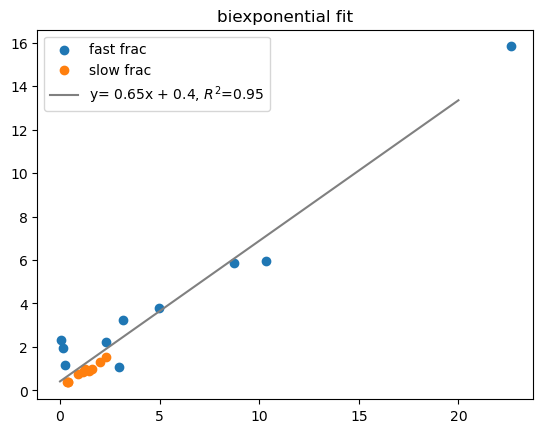

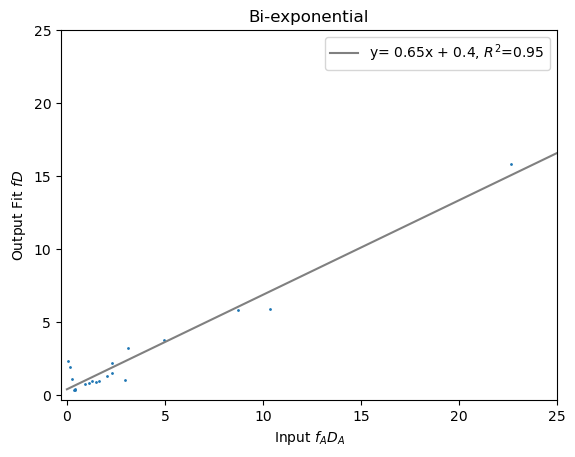

relative percent difference
fast fD  -14.38341%


NameError: name 'FitmedfDs' is not defined

In [60]:
filename = 'Simulated_IVIM_Curves_20250202-1921.xlsx'
fileloc = '/Users/miraliu/Desktop/PostDocCode/IVIM_Fitting_Methods/' + filename

df_TrueParams = pd.read_excel(fileloc,sheet_name = 'Parameters') 
df_TrueParams=df_TrueParams.rename(columns={c: 'true '+c for c in df_TrueParams.columns if c not in ['Run Number', 'Unnamed']})
df_TrueParams=df_TrueParams.rename(columns={c: c+'tion' for c in df_TrueParams.columns if 'frac' in c})

# AN_A_SNR_50 = averaged with noise (AN) Anomalous (A), with SNR=100
df_AveragedNoise = pd.read_excel(fileloc,sheet_name = 'AveragedNoise_anomalous_SNR_100') 
df_AveragedNoise = df_AveragedNoise.fillna(0)


b_values=np.array([0,50,100,150,200,250,300,500,700,900])

# trying bi-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
TrueGammas = []
FitFracs = []
FitDiffs = []
r2_fit = []
compartment_number=[]
for j in range(10):
    
    ## now using Matlab code for Algorithm1
    struct = eng.Algorithm2(b_values,df_AveragedNoise.iloc[j,2:].to_numpy().astype(float))
    [D,Ds,f, rsq]=list(struct.values())

    diffusions = [Ds, D]
    fracs=[f,1-f]
    
    
    ## order given true values from fast to slow just in case
    givengammas = np.array([df_TrueParams['true fast gamma'].iloc[j],df_TrueParams['true slow gamma'].iloc[j]])
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    TrueGammas.append(list(givengammas))
  
    
    y_pred = biexp_func(b_values, fracs[0], fracs[1], diffusions[0], diffusions[1])
    r2_goodness = r2_score(df_AveragedNoise.iloc[j,2:], y_pred)
    if r2_goodness>0:
        r2_fit.append(r2_goodness)
    else:
        r2_fit.append(0)
    
print(f'goodness of fit: r2={np.mean(r2_fit):.5f}±{np.std(r2_fit):.5f}') 
TruefastfDs= 1000*np.array(TrueFracs)[:,0]*((np.array(TrueDiffs)[:,0]))
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

TrueslowfDs= 1000*np.array(TrueFracs)[:,1]*(np.array(TrueDiffs)[:,1])
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]



AllTruefD = np.array(list(TruefastfDs)+list(TrueslowfDs))
allFitfD = np.array(list(FitfastfDs)+list(FitslowfDs))

pl.scatter(TruefastfDs, FitfastfDs,label= 'fast frac')
pl.scatter(TrueslowfDs, FitslowfDs,label= 'slow frac')

x = np.linspace(0,20,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(AllTruefD,allFitfD)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('biexponential fit')
pl.show()


pl.scatter(AllTruefD, allFitfD, s=1)
x = np.linspace(0,25,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(AllTruefD,allFitfD)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('Bi-exponential')
pl.xlabel('Input $f_AD_A$')
pl.ylabel('Output Fit $fD$')
pl.xlim(-0.3,25)
pl.ylim(-0.3,25)
pl.show()




print('relative percent difference')
print(f'fast fD  {200*np.median((FitfastfDs-TruefastfDs)/(TruefastfDs +FitfastfDs )):.5f}%')
print(f'med fD {200*np.median((FitmedfDs-TruemedfDs)/(TruemedfDs + FitmedfDs)):.5f}%')
print(f'slow fD {200*np.median((FitslowfDs-TrueslowfDs)/(TrueslowfDs + FitslowfDs)):.5f}%')

print('\nrelative abs percent difference')
print(f'fast fD  {200*np.median(abs(FitfastfDs-TruefastfDs)/(TruefastfDs +FitfastfDs )):.5f}%')
print(f'med fD {200*np.median(abs(FitmedfDs-TruemedfDs)/(TruemedfDs + FitmedfDs)):.5f}%')
print(f'slow fD {200*np.median(abs(FitslowfDs-TrueslowfDs)/(TrueslowfDs + FitslowfDs)):.5f}%')


print('\npercent bland altman')
blandalt_calc(FitfastfDs,TruefastfDs,'fast fD')
blandalt_calc(FitmedfDs,TruemedfDs,'med fD')
blandalt_calc(FitslowfDs,TrueslowfDs,'slow fD')
blandalt_calc(allFitfD,AllTruefD,'all fD')





print('individual f and D')



TruefastfDs= np.array(TrueFracs)[:,0]
FitfastfDs = np.array(FitFracs)[:,0]

TrueslowfDs= np.array(TrueFracs)[:,1]
FitslowfDs = np.array(FitFracs)[:,1]



AllTruefD = np.array(list(TruefastfDs)+list(TrueslowfDs))
allFitfD = np.array(list(FitfastfDs)+list(FitslowfDs))


x = np.linspace(0,1,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(AllTruefD,allFitfD)
pl.scatter(AllTruefD,allFitfD)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('biexponential fit f')
pl.show()
print('relative percent difference')
print(f'fast f  {200*np.median((FitfastfDs-TruefastfDs)/(TruefastfDs +FitfastfDs )):.5f}%')
print(f'med f {200*np.median((FitmedfDs-TruemedfDs)/(TruemedfDs + FitmedfDs)):.5f}%')
print(f'slow f {200*np.median((FitslowfDs-TrueslowfDs)/(TrueslowfDs + FitslowfDs)):.5f}%')



print('\nrelative abs percent difference')
print(f'fast f  {200*np.median(abs(FitfastfDs-TruefastfDs)/(TruefastfDs +FitfastfDs )):.5f}%')
print(f'med f {200*np.median(abs(FitmedfDs-TruemedfDs)/(TruemedfDs + FitmedfDs)):.5f}%')
print(f'slow f {200*np.median(abs(FitslowfDs-TrueslowfDs)/(TrueslowfDs + FitslowfDs)):.5f}%')


print('\npercent bland altman')
blandalt_calc(FitfastfDs,TruefastfDs,'fast f')
blandalt_calc(FitmedfDs,TruemedfDs,'med f')
blandalt_calc(FitslowfDs,TrueslowfDs,'slow f')




TruefastfDs= 1000*(np.array(TrueDiffs)[:,0])
FitfastfDs = 1000*np.array(FitDiffs)[:,0]

TrueslowfDs= 1000*(np.array(TrueDiffs)[:,1])
FitslowfDs = 1000*np.array(FitDiffs)[:,1]


AllTruefD = np.array(list(TruefastfDs)+list(TrueslowfDs))
allFitfD = np.array(list(FitfastfDs)+list(FitslowfDs))



x = np.linspace(0,100,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(AllTruefD,allFitfD)
pl.scatter(AllTruefD,allFitfD)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('biexponential fit D')
pl.show()
print('relative percent difference')
print(f'fast D  {200*np.median((FitfastfDs-TruefastfDs)/(TruefastfDs +FitfastfDs )):.5f}%')
print(f'med D {200*np.median((FitmedfDs-TruemedfDs)/(TruemedfDs + FitmedfDs)):.5f}%')
print(f'slow D {200*np.median((FitslowfDs-TrueslowfDs)/(TrueslowfDs + FitslowfDs)):.5f}%')


print('\nrelative abs percent difference')
print(f'fast D  {200*np.median(abs(FitfastfDs-TruefastfDs)/(TruefastfDs +FitfastfDs )):.5f}%')
print(f'med D {200*np.median(abs(FitmedfDs-TruemedfDs)/(TruemedfDs + FitmedfDs)):.5f}%')
print(f'slow D {200*np.median(abs(FitslowfDs-TrueslowfDs)/(TrueslowfDs + FitslowfDs)):.5f}%')


print('\npercent bland altman')
blandalt_calc(FitfastfDs,TruefastfDs,'fast D')
blandalt_calc(FitmedfDs,TruemedfDs,'med D')
blandalt_calc(FitslowfDs,TrueslowfDs,'slow D')



